# Fraud Analytics Mini-Case: SQL + Python (DuckDB, pandas, matplotlib)

In [7]:
# Ensure duckdb + plotting libs are available in this runtime.
!pip -q install duckdb pandas matplotlib

In [8]:
# Imports
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Load data
df = pd.read_csv("/content/transactions.csv")
df.head()


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [10]:
# SQL setup (DuckDB)
con = duckdb.connect()
con.register("transactions", df)

# Quick sanity check - row count in SQL
con.execute("SELECT COUNT(*) AS n_rows FROM transactions;").df()

,n_rows
0,299695


In [11]:
# List available fields
df.columns

Index(['transaction_id', 'user_id', 'account_age_days',
       'total_transactions_user', 'avg_amount_user', 'amount', 'country',
       'bin_country', 'channel', 'merchant_category', 'promo_used',
       'avs_match', 'cvv_result', 'three_ds_flag', 'transaction_time',
       'shipping_distance_km', 'is_fraud'],
      dtype='object')

In [12]:
# Fraud label distribution
df["is_fraud"].value_counts(dropna=False)

,count
is_fraud,
0,293083
1,6612


Across 299,695 transactions, overall fraud rate is approx 2.21%. Fraud is concentrated in web channel segment (approx 3.56%), approx 4× higher than app ( approx 0.80%) Non-3DS transactions (approx 6.75%) are approx 7× higher than 3DS (approx 0.96%). Shipping distance shows a significant increase for 500km+ deliveries (approx 15.9%). Fail/fail transactions show approx 20× higher fraud rate than pass/pass. Hour level anomaly scan highlights several time windows with elevated fraud rates.

Dataset overview


*   File: transactions.csv (299,695 rows), one row = one transaction.

*   is_fraud is the label Im using (1 = fraud, 0 = not fraud).

*   I mainly look at transaction_time, channel, three_ds_flag, avs_match, cvv_result, shipping_distance_km, and country/bin_country.







In [13]:
# SQL helper
def q(sql):
    return con.execute(sql).df()

In [14]:
# Overall transactions and fraud rate
q("""
SELECT
  COUNT(*) AS n_transactions,
  AVG(is_fraud) AS fraud_rate
FROM transactions;
""")

,n_transactions,fraud_rate
0,299695,0.022062


In [15]:
# Fraud rate by channel
q("""
SELECT
  channel,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate,
  AVG(amount) AS avg_amount
FROM transactions
GROUP BY channel
ORDER BY fraud_rate DESC, n DESC;
""")

,channel,n,fraud_rate,avg_amount
0,web,152226,0.035644,182.670108
1,app,147469,0.008042,171.482876


In [16]:
# Fraud rate by country vs BIN country
q("""
SELECT
  country,
  bin_country,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY country, bin_country
HAVING COUNT(*) >= 50
ORDER BY fraud_rate DESC, n DESC
LIMIT 20;
""")

,country,bin_country,n,fraud_rate
0,TR,IT,294,0.176871
1,FR,US,282,0.170213
2,TR,FR,235,0.161702
3,RO,ES,268,0.160448
4,TR,NL,274,0.156934
5,RO,TR,258,0.147287
6,ES,TR,247,0.145749
7,NL,GB,275,0.145455
8,TR,PL,262,0.145038
9,US,TR,308,0.142857


In [19]:
# Fraud rate by shipping distance bucket
q("""
SELECT
  CASE
    WHEN shipping_distance_km IS NULL THEN 'unknown'
    WHEN shipping_distance_km < 5 THEN '<5km'
    WHEN shipping_distance_km < 50 THEN '5-50km'
    WHEN shipping_distance_km < 500 THEN '50-500km'
    ELSE '500km+'
  END AS distance_bucket,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY distance_bucket
ORDER BY
  CASE distance_bucket
    WHEN '<5km' THEN 1
    WHEN '5-50km' THEN 2
    WHEN '50-500km' THEN 3
    WHEN '500km+' THEN 4
    ELSE 5
  END;
""")

,distance_bucket,n,fraud_rate
0,<5km,2776,0.008646
1,5-50km,24644,0.009171
2,50-500km,247239,0.009642
3,500km+,25036,0.158891


In [20]:
# Fraud rate by 3DS flag (authentication signal)
q("""
SELECT
  three_ds_flag,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate,
  AVG(amount) AS avg_amount
FROM transactions
GROUP BY three_ds_flag
ORDER BY fraud_rate DESC;
""")

,three_ds_flag,n,fraud_rate,avg_amount
0,0,64558,0.067521,197.141310
1,1,235137,0.009582,171.680762


In [21]:
# Fraud rate by AVS + CVV outcome (payment verification signals)
q("""
SELECT
  avs_match,
  cvv_result,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY avs_match, cvv_result
HAVING COUNT(*) >= 50
ORDER BY fraud_rate DESC, n DESC
LIMIT 25;
""")

,avs_match,cvv_result,n,fraud_rate
0,0,0,25797,0.145792
1,0,1,22754,0.040960
2,1,0,12531,0.024260
3,1,1,238613,0.006768


In [22]:
# Top high risk users (min 10 transactions)
q("""
WITH per_user AS (
  SELECT
    user_id,
    COUNT(*) AS n,
    AVG(is_fraud) AS fraud_rate,
    AVG(amount) AS avg_amount
  FROM transactions
  GROUP BY user_id
  HAVING COUNT(*) >= 10
)
SELECT
  user_id, n, fraud_rate, avg_amount,
  DENSE_RANK() OVER (ORDER BY fraud_rate DESC, n DESC) AS risk_rank
FROM per_user
ORDER BY risk_rank
LIMIT 20;
""")

,user_id,n,fraud_rate,avg_amount,risk_rank
0,2303,49,0.591837,451.637347,1
1,4444,44,0.590909,557.046136,2
2,1093,56,0.589286,405.250536,3
3,3542,46,0.586957,519.076304,4
4,1215,58,0.586207,332.169310,5
5,3751,41,0.585366,133.121707,6
6,5084,41,0.585366,352.133902,6
7,946,50,0.580000,329.909800,7
8,5328,50,0.580000,586.865200,7
9,2492,50,0.580000,476.658000,7


In [23]:
# Fraud rate anomalies by hour (z-score)
q("""
WITH base AS (
  SELECT
    DATE_TRUNC('hour', CAST(transaction_time AS TIMESTAMP)) AS hour,
    COUNT(*) AS n,
    AVG(is_fraud) AS fraud_rate
  FROM transactions
  GROUP BY 1
  HAVING COUNT(*) >= 50
),
stats AS (
  SELECT AVG(fraud_rate) AS avg_fr, STDDEV_POP(fraud_rate) AS std_fr
  FROM base
)
SELECT
  b.hour, b.n, b.fraud_rate,
  (b.fraud_rate - s.avg_fr) / NULLIF(s.std_fr, 0) AS z_score
FROM base b
CROSS JOIN stats s
WHERE ABS((b.fraud_rate - s.avg_fr) / NULLIF(s.std_fr, 0)) >= 2
ORDER BY ABS(z_score) DESC
LIMIT 20;
""")

,hour,n,fraud_rate,z_score
0,2024-06-05 17:00:00,51,0.117647,4.948843
1,2024-06-10 04:00:00,50,0.100000,4.049081
2,2024-01-26 11:00:00,52,0.096154,3.852979
3,2024-02-02 02:00:00,50,0.080000,3.029351
4,2024-10-01 20:00:00,51,0.078431,2.949373
5,2024-02-20 15:00:00,51,0.078431,2.949373
6,2024-08-12 06:00:00,51,0.078431,2.949373
7,2024-07-24 22:00:00,52,0.076923,2.872470
8,2024-08-08 10:00:00,52,0.076923,2.872470
9,2024-10-09 09:00:00,52,0.076923,2.872470


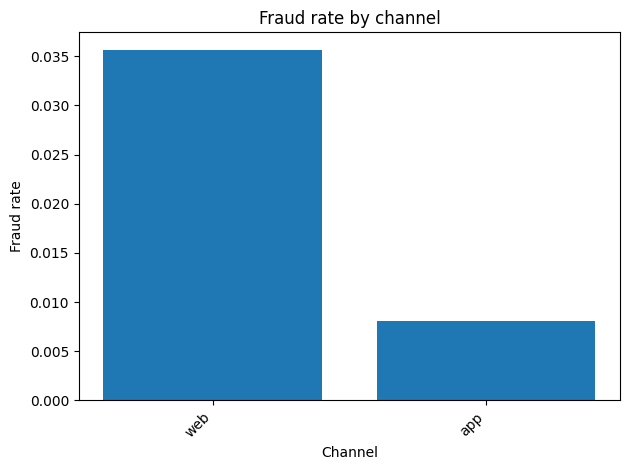

In [25]:
# Visualise fraud rate by channel
by_channel = q("""
SELECT channel, COUNT(*) AS n, AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY channel
ORDER BY fraud_rate DESC;
""")

plt.figure()
plt.bar(by_channel["channel"], by_channel["fraud_rate"])
plt.title("Fraud rate by channel")
plt.xlabel("Channel")
plt.ylabel("Fraud rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

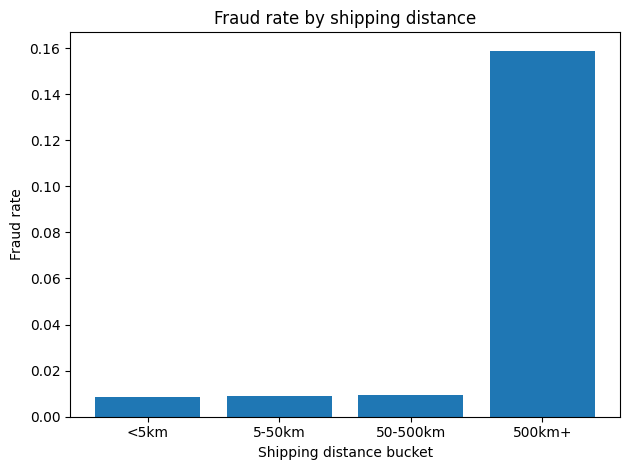

In [26]:
# Visualise fraud rate by shipping distance bucket
by_dist = q("""
SELECT
  CASE
    WHEN shipping_distance_km IS NULL THEN 'unknown'
    WHEN shipping_distance_km < 5 THEN '<5km'
    WHEN shipping_distance_km < 50 THEN '5-50km'
    WHEN shipping_distance_km < 500 THEN '50-500km'
    ELSE '500km+'
  END AS distance_bucket,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY distance_bucket;
""")

# Stable ordering for display
order = ["<5km","5-50km","50-500km","500km+","unknown"]
by_dist["distance_bucket"] = pd.Categorical(by_dist["distance_bucket"], categories=order, ordered=True)
by_dist = by_dist.sort_values("distance_bucket")

plt.figure()
plt.bar(by_dist["distance_bucket"], by_dist["fraud_rate"])
plt.title("Fraud rate by shipping distance")
plt.xlabel("Shipping distance bucket")
plt.ylabel("Fraud rate")
plt.tight_layout()
plt.show()

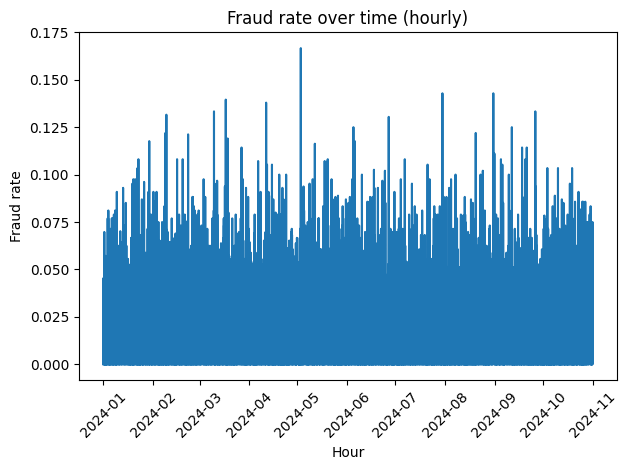

In [27]:
# Visualise fraud rate over time (hourly)
hourly = q("""
SELECT
  DATE_TRUNC('hour', CAST(transaction_time AS TIMESTAMP)) AS hour,
  COUNT(*) AS n,
  AVG(is_fraud) AS fraud_rate
FROM transactions
GROUP BY 1
ORDER BY 1;
""")

plt.figure()
plt.plot(hourly["hour"], hourly["fraud_rate"])
plt.title("Fraud rate over time (hourly)")
plt.xlabel("Hour")
plt.ylabel("Fraud rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()